In [317]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.optimize import curve_fit
import warnings
#%matplotlib widget
%matplotlib inline

import shutil
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
SPLIT_MERGED_LOG_PATH = '../dl_logs/merged_split_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'
TO_MERGE_LOG_PATH = '../dl_logs/to_merge/'

MERGED_STOCH_LOG_PATH = '../dl_logs/merged_um_stoch_logs/'
MERGED_CORR_LOG_PATH = '../dl_logs/merged_um_corr_logs/'

EXPERIMENTAL_LOG_PATH = '../dl_logs/experimental/'

DL_PATH = '../dl_logs/'


In [346]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False, 
                  parse_hparams=True, only_max_step=False, one_fold=None):
    values = defaultdict(list)
    hparams_dict = dict()
    
    if os.path.isdir(logs_path) and (logs_path.endswith('metrics') or logs_path.endswith('metrics/')):
        metrics_path = logs_path
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if ('DS_Store' not in el) and 
                                             ('hparams' not in el) and 
                                             (os.path.isdir(join(metrics_path, el)))]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
    
    with open(r'./failed_relaunch_jobs.txt', 'a') as fp:
        for fold_path in list_folds:
            logs_fold_path = join(metrics_path, fold_path)
            match = re.search("fold_([0-9]+)", fold_path)
            fold_nb = int(match.group(1))
            fold_string=f"fold_{fold_nb}"

            if (not one_fold) or (one_fold and fold_nb==one_fold):

                if verbose > 1: print(fold_string, end='  ')
                event_acc = EventAccumulator(logs_fold_path)
                event_acc.Reload()
                for tag in metrics_to_plot:
                    try:
                        _, step_nums, vals = zip(*event_acc.Scalars(tag))
                        if re.search('part[0-9]+', fold_path):
                                vals = vals[1:] # discard the val verification runs for a relaunch
                        if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                            if len(vals) < 2 and delete_dir:
                                shutil.rmtree(logs_fold_path)
                                print(f"{bcolors.FAIL}{logs_fold_path}{bcolors.ENDC} deleted")

                            print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                            return defaultdict(list), dict()
                        
                        elif tag == 'val_acc':
                            if verbose > 1: print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                            if max_step > 50000 and min(vals[int(len(vals)/2):]) < 0.1:
                                print(f'{logs_path} is considered a failed restart')
                                fp.write(re.search('([0-9]{7})', logs_path).group(1) + '\n')

                        elif tag == 'val_step':
                            max_step = int(max(vals))
                            if verbose > 1: print(f"Max_step: {max_step}", end=" ")
                            if only_max_step: 
                                return max_step
                        
                        values[tag].append(list(np.around(vals, 4)))
                        values[f'{tag}_step'].append(list(step_nums))
                        values['fold_nb'].append(fold_nb)
                    except Exception as e:
                        print(f'Error {e}')
                        print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}")
                        return defaultdict(list), dict()
                
        if verbose > 1: print()

    print_folds_str=f'#folds: {len(list_folds)}'
    if len(list_folds) < 30:
        print(f"{bcolors.WARNING}{print_folds_str}{bcolors.ENDC}", end='   || ')
    else:
        print(print_folds_str, end='   || ')
    
    if parse_hparams:
        with open(join(logs_fold_path, 'hparams.yaml')) as file:
            hparams_dict = yaml.load(file, Loader=Loader)

        fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
        hparams_dict.pop('args', None)
        
    return values, hparams_dict


In [371]:
def neg_log(x, a):
    return a * np.log(x)

def neg_exp(x, a, b, c):
    if isinstance(x, list):
        return [-np.exp(-el*a+b)+c for el in x]
    else:
        return -np.exp(-x*a+b)+c

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=1000, curvefit=False, debug=False):
    interp_values = defaultdict(list)
    max_epochs_real_all = max([max(el) for el in x_values])
    min_epochs_real_all = min([min(el) for el in x_values])
    x_all = np.arange(min_epochs_real_all, max_epochs_real_all, step=100.0)
    multiple_folds = len(x_values) > 1

    for metric_name in metrics_to_plot:
        y_vals_interp, x_vals_interp = [], []
        
        if multiple_folds:
            for steps, vals in zip(x_values, values[metric_name]):
                min_epochs_real, max_epochs_real = max((min(steps)/100)*100 - 1000, 0), min((max(steps)/100)*100 + 1000, max_epochs_real_all)
                #print(min_epochs_real, max_epochs_real)
                x_before = np.arange(0, min_epochs_real, step=100.0)
                x_before[:] = np.NaN
                x_after = np.arange(max_epochs_real, max_epochs_real_all, step=100.0)
                x_after[:] = np.NaN

                x_middle = np.arange(min_epochs_real+100, max_epochs_real, step=100.0) # should overlap perfectly w a portion of xall
                if x_all.shape[0] < x_before.shape[0] + x_middle.shape[0] + x_after.shape[0]:   
                    x_after = x_after[:x_after.shape[0]-1]
                if x_all.shape[0] > x_before.shape[0] + x_middle.shape[0] + x_after.shape[0]:   
                    x_after = np.append(x_after, np.nan)
                x = np.concatenate((x_before, x_middle, x_after), axis=0)
       
                y_middle = np.interp(x_middle, steps, vals)
                y = np.concatenate((x_before, y_middle, x_after), axis=0)

                #if debug: 
                #    print(x_before.shape, x_middle.shape,y_middle.shape, x_after.shape, x_before.shape[0]+ x_middle.shape[0]+ x_after.shape[0])
                #    print(x_all.shape)
                y_vals_interp.append(y)
                x_vals_interp.append(x)
        else:
            steps, vals = x_values[0], values[metric_name][0]
            min_epochs_real, max_epochs_real = max((min(steps)/100)*100 - 1000, 0), min((max(steps)/100)*100 + 1000, max_epochs_real_all)
            x_all = np.arange(min_epochs_real, max_epochs_real, step=100.0)
            y_vals_interp = np.interp(x_all, steps, vals)

        y_vals_interp = np.stack(y_vals_interp)

        if multiple_folds:
             with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                y_vals_interp_mean = np.nanmean(y_vals_interp, axis=0) # take mean of all different parts
        else:
            y_vals_interp_mean = y_vals_interp
        x_temp = np.arange(len(y_vals_interp_mean))
        nan_pos = np.isnan(y_vals_interp_mean)
        #if debug:
        #    print(y_vals_interp_mean.shape)
        y_vals_interp_mean = np.interp(x_temp, x_temp[~nan_pos], y_vals_interp_mean[~nan_pos])

        #if debug:
        #    print(y_vals_interp_mean.shape, x_all.shape)
        if(x_all.shape[0] != y_vals_interp_mean.shape[0] and np.isclose(x_all.shape[0], y_vals_interp_mean.shape[0], 2)):
            if x_all.shape[0] > y_vals_interp_mean.shape[0]:
                x_all = x_all[:y_vals_interp_mean.shape[0]]
            else:
                y_vals_interp_mean = y_vals_interp_mean[:x_all.shape[0]]
                for el in y_vals_interp:
                    el = el[:x_all.shape[0]]
        #if debug:
        #    print(y_vals_interp_mean.shape, x_all.shape)


        x_standardised = np.linspace(0, max_epochs_real_all, num=tot_num_values) # standardised x that is the same for all folds
        y_vals_interp_mean = np.interp(x_standardised, x_all, y_vals_interp_mean) # move from x_all to x_standard

        x_values_flat = [item for x_val in x_values for item in x_val]
        metric_values_flat = [item for val in values[metric_name] for item in val]
        
        interp_values[f'{metric_name}_interp_steps'] = list(x_standardised)
        interp_values[f'{metric_name}_interp_mean'] = y_vals_interp_mean
        #var2 = np.sum((np.array([el - np.mean(y_vals_interp, axis=0) for el in y_vals_interp]))**2, axis=0) / len(y_vals_interp)
        if multiple_folds:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                var_w_nans = np.nanvar(y_vals_interp, axis=0)
            #if debug: print('qqqq', var_w_nans.shape, y_vals_interp.shape)
            var_w_nans[np.isnan(var_w_nans)] = 0
            var_w_nans = np.interp(x_standardised, x_all, var_w_nans)
        else:
            var_w_nans = np.zeros(x_standardised.shape)
        interp_values[f'{metric_name}_interp_var'] = var_w_nans
        
        if 'acc' in metric_name and curvefit:
            a_opt, _ = curve_fit(neg_exp, x, interp_values[f'{metric_name}_interp_mean'], [0.00001, 0.1, 0.1]) # shouldnt be used here bc requires many more points (continuous)
            interp_values[f'{metric_name}_curvefit_var'] = np.min([neg_exp(list(x), *a_opt), np.ones(len(list(x)))], axis=0)
    
    return interp_values, (x_values_flat, metric_values_flat)

In [372]:
def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None, 
                 values_flat=None, plot_points=False, plot_curvefit=False):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])
        
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        
        # if we have too many values at convergence
        cutoff = [i for i, n in enumerate(mean_val) if n > 0.99]
        if len(cutoff) < 200:
            cutoff = -1
        else:
            cutoff=cutoff[199]
            
        epochs, mean_val,var_val = epochs[:cutoff], mean_val[:cutoff],var_val[:cutoff]    

        p=ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor=p[-1].get_color())
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(len(epochs)) * 0.95, '--k', linewidth=1, alpha=0.6)
            if plot_points and values_flat:
                ax[i].scatter(values_flat[0], values_flat[1], color=color, marker='o', s=3, alpha=0.25)
            if plot_curvefit:
                ax[i].plot(interp_values_df[f'{metric_name}_interp_steps'], interp_values_df[f'{metric_name}_curvefit_var'], '--', color=p[-1].get_color(), lw=1, alpha=0.7)
            
        if metric_name == 'val_acc':
            val_acc_curve = p[0].get_data()
        
    return val_acc_curve

def create_run_dict(hparams_dict, metric_values, ckpt_name):
    hparams_dict['name'] = ckpt_name
    hparams_dict['eval_steps'] = []
    hparams_dict['best_score'] = max([max(el) for el in metric_values['val_acc']])
    return hparams_dict
        
        
def parse_regex(ckpt_name):
    match=re.search(re.compile("(?:(mnist)|_d([0-9]+))"), ckpt_name)
    depth=match.group(1)
    match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
    b_len=int(match.group(1))
    match=re.search(re.compile("_rep([0-9]+)"), ckpt_name)
    repetition_nb=int(match.group(1))

    #patt = "(?:merged_)*([0-9]+)_([0-9]+)_[0-9]+_([a-z]+(?:corr)*_(?:um|rand|split)_b[0-9]+_*(d[0-9]+)*_*(s[0-9]*)*_+h[0-9]+_lr[0-9.]+_rep[0-9]+)"
    patt = '(?:merged_)*([0-9]{7})_([0-9]{4})_[0-9]{4}_((?:synth|mnist)(?:corr)*_(?:um|rand|split)_b[0-9]+_(d[0-9]+)_*(?:stoch)*(s[0-9]*)*_h[0-9]+_lr[0-9.]+_rep[0-9]+)'
    matched = re.match(patt, ckpt_name)
    hash1 = matched.group(3) # create hash
    job_id = int(matched.group(1))
    date_launched = int(matched.group(2))

    return depth, b_len, repetition_nb, hash1, job_id, date_launched

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=0, delete_dir=False, debug=False):
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(15,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    tot_len_ckpt = len(logs_paths)
    all_metric_values_dict = dict()
    all_hparams_dict = dict()
    is_labeled = []
    max_rep = defaultdict(lambda:1)
    val_accs_dict = dict()
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name, end='  ')

        depth, b_len, repetition_nb, hash1, job_id, date_launched = parse_regex(ckpt_name)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        max_rep[hash1_no_rep] = max(max_rep[hash1_no_rep], repetition_nb)

        metric_values, hparams_dict = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)  
        hparams_dict['name'] = ckpt_name
        hparams_dict['job_id'] = job_id
        hparams_dict['date'] = date_launched
        
        # USED TO MERGE TWO PARTS OF THE SAME RUN
        #if hash1 in all_metric_values_dict.keys() and np.isclose(int(all_hparams_dict[hash1]['job_id']), job_id, atol=4):
        #    #merge...
        #    for key1 in all_metric_values_dict[hash1].keys():
        #        all_metric_values_dict[hash1][key1].append(metric_values[key1])
        #   list_steps = all_metric_values_dict[hash1]['val_step']
            
        #    for key1, metric_list in all_metric_values_dict[hash1].items():   
        #        all_metric_values_dict[hash1][key1] = [x for _, x in sorted(zip(list_steps, metric_list))]
        #else:
        all_metric_values_dict[hash1] = metric_values
        all_hparams_dict[hash1] = hparams_dict
            
        #highscore_table.append(create_run_dict(hparams_dict, metric_values, ckpt_name))   
    successfull_run_keys = [hash1 for hash1 in all_metric_values_dict.keys() if len(all_metric_values_dict[hash1]['val_acc']) > 0]
    
    for i, hash1 in enumerate(sorted(successfull_run_keys)):
        metric_values, hparams_dict = all_metric_values_dict[hash1], all_hparams_dict[hash1]
        
        if verbose > 0: print(hash1)
        interp_values, values_flat = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                                   values=metric_values, x_values=metric_values['val_step'],
                                                   tot_num_values=tot_num_values, debug=debug)
        interp_values_df = pd.DataFrame(interp_values)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        #all_metric_values_dict[hash1]['val_acc_interp'] = interp_values_df['val_acc_interp_mean']
        
        hash_is_labeled = True
        if hash1_no_rep not in is_labeled:
            hash_is_labeled = False
            is_labeled.append(hash1_no_rep)
            
        if color_patt == None:
            color_nb = is_labeled.index(hash1_no_rep)
            cmap = plt.get_cmap(cm_names[color_nb%len(cm_names)])
            #cmap = plt.get_cmap(cm_names[0])
            #color = cmap(np.log10(hparams_dict['b_len']+1)/np.log10(1e4)) #cmap(lightness)
            color=cmap(0.5)
        elif color_patt == 'discrete':
            color = None
            
        label = None
        if plot_legend == 1 and not hash_is_labeled:
            label = str(hparams_dict['date'])+str(hash1_no_rep)
           
        line_points_vals = plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=None, color=color, values_flat=values_flat)
        val_accs_dict[hash1] = line_points_vals
        
    if plot_legend > 0 and len(successfull_run_keys) > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
        
    return highscore_table, val_accs_dict


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=0, delete_dir=False, debug=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]+)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]+)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    val_accs_dict=dict()
    if len(logs_paths) > 0:
        highscore_table, val_accs_dict = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                           name=plot_name, tot_num_values=10000, plot_legend=1,
                                                           threshold=threshold, color_patt=None, verbose=verbose, 
                                                           delete_dir=delete_dir, debug=debug)
        plt.show()
    return val_accs_dict




In [373]:
def compute_integral_values(val_accs_dict, verbose=False):
    hash_b1 = None
    b1_curve = None
    b0_max_step = 0
    for hash1 in val_accs_dict.keys():  ## on soustrait tt a B1
        if '_b1_' in hash1:
            hash_b1 = hash1
            b1_curve = val_accs_dict[hash1]
            if verbose > 0: print('b1 selected: ', hash_b1)
            del val_accs_dict[hash1]
            break
            
    if b1_curve == None:
        print(f"{bcolors.FAIL}ERROR: No b1 run found as baseline{bcolors.ENDC}")
        return {}, '', 0
    
    integral_vals = dict()
    for hash1, curve1 in val_accs_dict.items(): # curve1 is a tuple with (x_vals, y_vals)
        if '_b0_' in hash1:
            b0_max_idx = np.argmax(curve1[1])
            b0_max_step = int(curve1[0][b0_max_idx])
            
        bx_y_interp, b1_y_interp, dx, max_val = align_curves(curve1, b1_curve)
        integral_vals[hash1] = riemann_sum(bx_y_interp, b1_y_interp, dx, max_val)
    
    return (integral_vals, hash_b1, b0_max_step)

def align_curves(points1, points2):
    max_val = int(min(max(points1[0]), max(points2[0])))
    
    idx1 = np.argwhere(points1[0] < max_val).flatten()
    idx2 = np.argwhere(points2[0] < max_val).flatten()
    new_points1 = [el[idx1] for el in points1]
    new_points2 = [el[idx2] for el in points2]
    x_interp_points = np.linspace(0, max_val, 100)
    points1_y_interp = np.interp(x_interp_points, new_points1[0], new_points1[1])
    points2_y_interp = np.interp(x_interp_points, new_points2[0], new_points2[1])
    dx = x_interp_points[1:] - x_interp_points[:-1]
    
    return points1_y_interp, points2_y_interp, dx, max_val

def riemann_sum(points1, points2, dx, max_val):
    y = points2 - points1
    res = np.sum((y[:-1] + y[1:]) * 0.5 * dx) / max_val
    return res
    

In [374]:
def plot_split_lens(ax, s_lens, y_lim_vals):      
    label1 = 'split_len'
    for i, s_len in enumerate(s_lens):
        ax[i//2][i%2].plot(np.ones(100)* s_len, np.linspace(y_lim_vals[0], y_lim_vals[1], 100), color='red', linestyle='--', label = label1)
        label1=None
    return ax

def plot_b_len_dist(ax, integral_values_dict_um, integral_values_dict_split, y_lim_vals, x_lim_vals, verbose=False):
    
    max_slope_um, max_slope_split = dict(), dict()
    for j, (mode, res_dict) in enumerate(zip(mode_list,[integral_values_dict_um, integral_values_dict_split])):
        for i, (b1_run_name, dx_dict) in enumerate(res_dict.items()):
            dx_dict, b0_max_idx = dx_dict
            b1_run_name = b1_run_name[3:b1_run_name.rfind('_')]
            x_val_list, y_val_list = [], []
            for run_hash1, run_value1 in dx_dict.items():
                matched = re.search('_b([0-9]+)_', run_hash1)
                if matched:
                    y_val_list.append(run_value1)
                    b_len = int(matched.group(1))
                    if b_len == 0: b_len = b0_max_idx
                    x_val_list.append(b_len)

            y_val_list = [y for _, y in sorted(zip(x_val_list, y_val_list))]
            x_val_list = [x for x, _ in sorted(zip(x_val_list, y_val_list))]

            label1 = mode if i==0 else None
            label2 = 'max_slope' if i==0 and mode == 'um' else None

            p=ax[i//2][i%2].plot(x_val_list, y_val_list, label=label1, lw=1)
            ax[i//2][i%2].scatter(x_val_list, y_val_list, marker='o')
            if mode == 'um':
                ax[i//2][i%2].set_title(f'UM distance from {b1_run_name}')

                ax[i//2][i%2].set_xscale('log')
                ax[i//2][i%2].set_xlabel('b length')
                ax[i//2][i%2].set_ylabel('Avg distance value')
                ax[i//2][i%2].set_ylim(y_lim_vals)
                bottom, top = ax[i//2][i%2].get_xlim()  #return the current ylim
                ax[i//2][i%2].set_xlim(x_lim_vals)

            if len(x_val_list) > 2:
                popt, _ = curve_fit(sigmoid, x_val_list, y_val_list, p0=[0.0001, 0.1, 0.1])
                a, b, c = popt

                if verbose: print('y = sig(%.3f*x + %.3f) + %.3f' % (a, b, c))
                new_x = np.arange(1,x_lim_vals[1],step=1)
                new_y = sigmoid(new_x, a, b, c)

                ax[i//2][i%2].plot(new_x, new_y, alpha=0.7, linestyle='--', color=p[0].get_color(), lw=1)

                idx_max = new_x[np.argmax(d_sigmoid(new_x, a, b, c))]
                ax[i//2][i%2].scatter(idx_max, sigmoid(idx_max, a, b, c), color='black', marker='+', label=label2)

                depth = int(re.search('_d([0-9]+)_', b1_run_name).group(1))
                if mode == 'um':
                    max_slope_um[depth] = 1/max(d_sigmoid(new_x, a, b, c))
                else:
                    max_slope_split[depth] = 1/max(d_sigmoid(new_x, a, b, c))
                #ax[i//2][i%2].plot(new_x, d_sigmoid(new_x, a, b, c), label=label1[1], color='blue')
                #ax[i//2][i%2].plot(new_x, sigmoid(new_x, a, b, c), label=None, color='red')
                #ax[i//2][i%2].plot(new_x, 1-sigmoid(new_x, a, b), label=None, color='green')
    return ax, max_slope_um, max_slope_split

def plot_max_slope_figure(ax, max_slope_um, max_slope_split):
    d_list_um = list(max_slope_um.keys())
    d_list_split = list(max_slope_split.keys())
    ax.set_title('1/max_slope: um vs. split')
    ax.bar(d_list_um+0.125*np.ones(len(d_list_um)),max_slope_um.values(), width=0.25, color='red', alpha=0.5, label='um')
    ax.bar(d_list_split-0.125*np.ones(len(d_list_split)), max_slope_split.values(), width=0.25, color='green', alpha=0.5, label='split')
    ax.set_xticks(d_list_um)
    ax.set_xlabel('depth')
    ax.set_ylabel('1/max_slope')
    
    return ax

def print_dict(dct):
    print("Dist values:", end='   ')
    for item, amount in dct.items():
        print("{}: {:.3f}".format(item, amount), end='  || ')
    print()

In [375]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'Purples', 'PuRd', 'ocean', 'cool', 'autumn','winter']
metrics_to_plot = ['val_step', 'val_loss', 'val_acc']
mode_list = ['um', 'split']


# Filtered graphs

## Synthetic Dataset

### Small verification run

#logged paths : 7 
merged_2747555_0807_0035_synthcorr_um_b0_d6_h120_lr2.0_rep0  fold_4  Max_step: 3705 #logged: 22, Max_acc: 0.998 fold_3  Max_step: 2632 #logged: 16, Max_acc: 1.0 fold_2  Max_step: 3394 #logged: 21, Max_acc: 1.0 fold_5  Max_step: 4294 #logged: 27, Max_acc: 1.0 fold_26  Max_step: 5041 #logged: 31, Max_acc: 1.0 fold_19  Max_step: 5011 #logged: 28, Max_acc: 0.998 fold_21  Max_step: 4146 #logged: 25, Max_acc: 1.0 fold_17  Max_step: 6497 #logged: 38, Max_acc: 1.0 fold_28  Max_step: 9857 #logged: 60, Max_acc: 1.0 fold_10  Max_step: 4437 #logged: 24, Max_acc: 1.0 fold_11  Max_step: 3158 #logged: 20, Max_acc: 1.0 fold_16  Max_step: 3238 #logged: 16, Max_acc: 1.0 fold_29  Max_step: 3387 #logged: 21, Max_acc: 1.0 fold_20  Max_step: 3175 #logged: 19, Max_acc: 1.0 fold_27  Max_step: 4985 #logged: 31, Max_acc: 1.0 fold_18  Max_step: 6095 #logged: 34, Max_acc: 1.0 fold_9  Max_step: 4368 #logged: 28, Max_acc: 0.998 fold_0  Max_step: 3561 #logged: 18, Max_acc: 1.0 fold_7  Max_step: 48

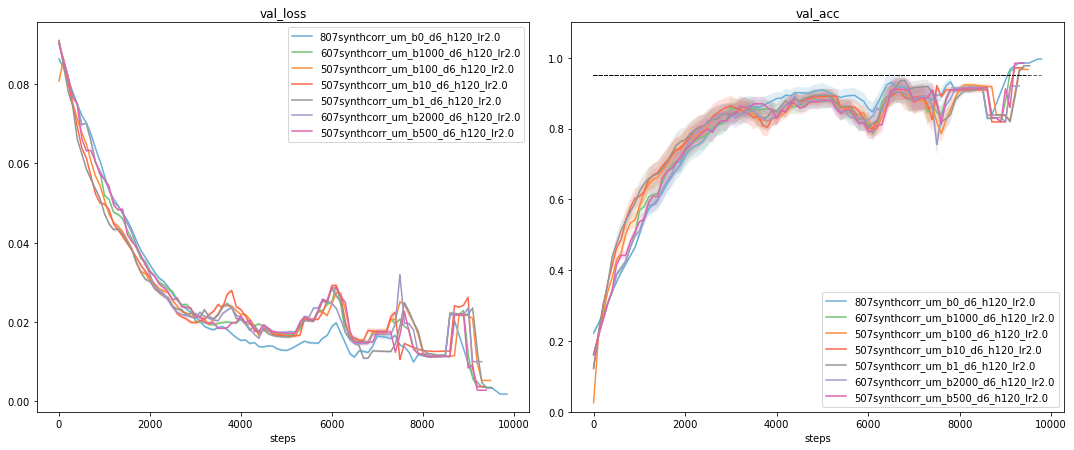

Dist values:   synthcorr_um_b0_d6_h120_lr2.0_rep0: 0.002  || synthcorr_um_b1000_d6_h120_lr2.0_rep0: 0.016  || synthcorr_um_b100_d6_h120_lr2.0_rep0: 0.010  || synthcorr_um_b10_d6_h120_lr2.0_rep0: -0.000  || synthcorr_um_b2000_d6_h120_lr2.0_rep0: 0.019  || synthcorr_um_b500_d6_h120_lr2.0_rep0: 0.014  || 


In [376]:
integral_values_dict_um, integral_values_dict_split, res_dict = dict(), dict(), dict()
#patts_to_search = ['synth(?:corr)*_um_b[0-9]*_d5_h60_lr2', 'synth(?:corr)*_um_b[0-9]*_d6_+h120_lr2', 'synth(?:corr)*_um_b[0-9]*_d7_+h250_lr2', 'synth(?:corr)*_um_b[0-9]*_d8_+h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
patts_to_search = ['synth_split_b[0-9]*_d5_s400', 'synth_split_b[0-9]*_d6_s400', 'synth_split_b[0-9]*_d7_s[0-9]*',
                   'synthcorr_split_b[0-9]*_d5', 'synthcorr_um_b[0-9]*_d6',
                  'synth_split_b[0-9]*_d5_stoch']

#patts_to_search = ['synth_split_b[0-9]*_d5_stoch'] # only stoch
patts_to_search = ['synthcorr_um_b[0-9]*_d6'] # only corr
#patts_to_search = ['2714079_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep16']
#patts_to_search = ['synth_split_b10_d6_s400_h120_lr1.0_rep23']
#patts_to_search = ['2714076_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep13']
# MERGED_LOG_PATH DL_LOG_PATH SPLIT_MERGED_LOG_PATH TO_MERGE_LOG_PATH MERGED_CORR_LOG_PATH 
# MERGED_STOCH_LOG_PATH EXPERIMENTAL_LOG_PATH TO_MERGE_LOG_PATH

for patt in patts_to_search: 
    val_accs_dict = plot_runs_w_regex(patt, 0.0, TO_MERGE_LOG_PATH, verbose=0, delete_dir=True, debug=True)
    integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
    print_dict(integral_values)
    res_dict[name] = (integral_values, b0_max_idx)

### Newly downloaded logs

#logged paths : 5 
merged_2697844_0107_1143_synth_split_b200_d5_s400_h60_lr1.0_rep26  #folds: 2   || merged_2714064_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep0  #folds: 63   || merged_2714093_0407_1112_synth_split_b1600_d5_s400_h60_lr1.0_rep0  #folds: 53   || merged_2697854_0107_1143_synth_split_b2000_d5_s400_h60_lr1.0_rep12  #folds: 22   || merged_2697862_0107_1143_synth_split_b5000_d5_s400_h60_lr1.0_rep10  #folds: 11   || 

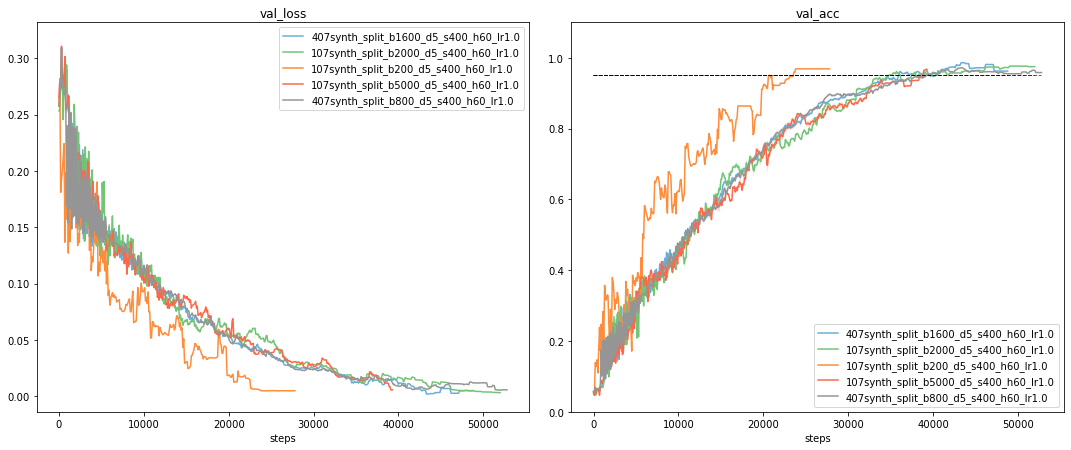

ERROR: No b1 run found as baseline
Dist values:   
#logged paths : 5 
merged_2697872_0107_1143_synth_split_b1_d6_s400_h120_lr1.0_rep1  #folds: 10   || merged_2697878_0107_1143_synth_split_b10_d6_s400_h120_lr1.0_rep7  #folds: 5   || merged_2697881_0107_1143_synth_split_b100_d6_s400_h120_lr1.0_rep0  #folds: 40   || merged_2714129_0507_0243_synth_split_b800_d6_s400_h120_lr1.0_rep0  #folds: 60   || merged_2714159_0507_0236_synth_split_b1600_d6_s400_h120_lr1.0_rep0  #folds: 60   || 

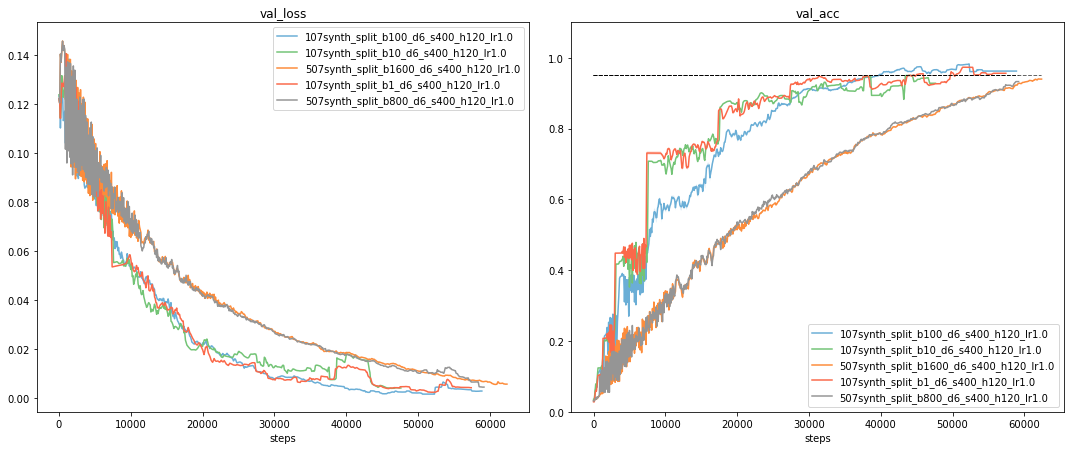

Dist values:   synth_split_b100_d6_s400_h120_lr1.0_rep0: 0.037  || synth_split_b10_d6_s400_h120_lr1.0_rep7: 0.011  || synth_split_b1600_d6_s400_h120_lr1.0_rep0: 0.219  || synth_split_b800_d6_s400_h120_lr1.0_rep0: 0.218  || 
#logged paths : 0 
ERROR: No b1 run found as baseline
Dist values:   
#logged paths : 0 
ERROR: No b1 run found as baseline
Dist values:   
#logged paths : 7 
merged_2747555_0807_0035_synthcorr_um_b0_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714226_0507_1351_synthcorr_um_b1_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714256_0507_1852_synthcorr_um_b10_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714286_0507_2047_synthcorr_um_b100_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714316_0507_2329_synthcorr_um_b500_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714346_0607_0132_synthcorr_um_b1000_d6_h120_lr2.0_rep0  #folds: 30   || merged_2714376_0607_0330_synthcorr_um_b2000_d6_h120_lr2.0_rep0  #folds: 30   || 

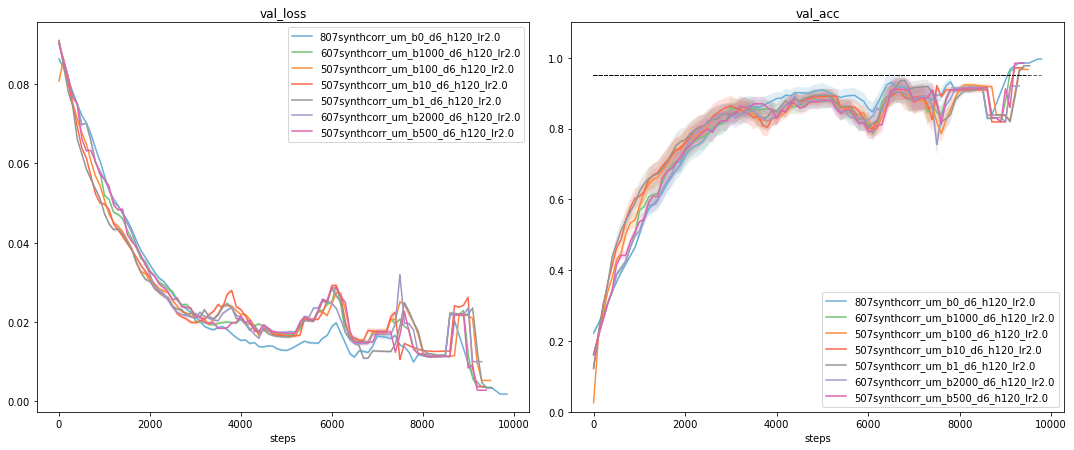

Dist values:   synthcorr_um_b0_d6_h120_lr2.0_rep0: 0.002  || synthcorr_um_b1000_d6_h120_lr2.0_rep0: 0.016  || synthcorr_um_b100_d6_h120_lr2.0_rep0: 0.010  || synthcorr_um_b10_d6_h120_lr2.0_rep0: -0.000  || synthcorr_um_b2000_d6_h120_lr2.0_rep0: 0.019  || synthcorr_um_b500_d6_h120_lr2.0_rep0: 0.014  || 
#logged paths : 2 
merged_2697961_0107_2343_synth_split_b1_d5_stochs400_h60_lr1.0_rep2  #folds: 7   || merged_2697966_0107_2343_synth_split_b10_d5_stochs400_h60_lr1.0_rep5  #folds: 3   || 

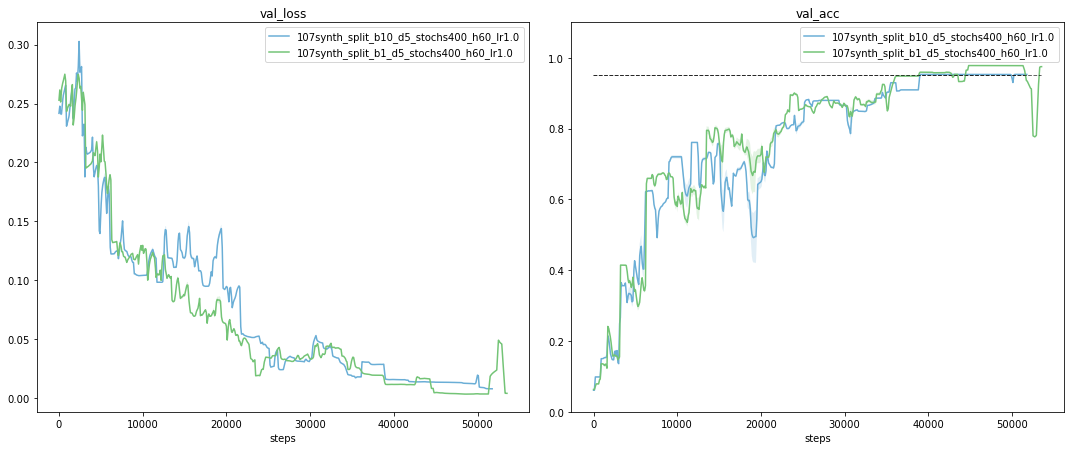

Dist values:   synth_split_b10_d5_stochs400_h60_lr1.0_rep5: 0.018  || 


In [367]:
integral_values_dict_um, integral_values_dict_split, res_dict = dict(), dict(), dict()
#patts_to_search = ['synth(?:corr)*_um_b[0-9]*_d5_h60_lr2', 'synth(?:corr)*_um_b[0-9]*_d6_+h120_lr2', 'synth(?:corr)*_um_b[0-9]*_d7_+h250_lr2', 'synth(?:corr)*_um_b[0-9]*_d8_+h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
patts_to_search = ['synth_split_b[0-9]*_d5_s400', 'synth_split_b[0-9]*_d6_s400', 'synth_split_b[0-9]*_d7_s[0-9]*',
                   'synthcorr_split_b[0-9]*_d5', 'synthcorr_um_b[0-9]*_d6',
                  'synth_split_b[0-9]*_d5_stoch']

#patts_to_search = ['synth_split_b[0-9]*_d5_stoch'] # only stoch
#patts_to_search = ['synthcorr_rm_b[0-9]*_d6'] # only corr
#patts_to_search = ['2735590']
#patts_to_search = ['synthcorr_um_b[0-9]*_d6']
# MERGED_LOG_PATH DL_LOG_PATH SPLIT_MERGED_LOG_PATH TO_MERGE_LOG_PATH MERGED_CORR_LOG_PATH MERGED_STOCH_LOG_PATH

for patt in patts_to_search: 
    val_accs_dict = plot_runs_w_regex(patt, 0.0, TO_MERGE_LOG_PATH, verbose=0, delete_dir=False)
    integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
    print_dict(integral_values)
    res_dict[name] = (integral_values, b0_max_idx)

### Run

#logged paths : 9 
merged_2550576_0706_0057_synth_um_b0_d5_h60_lr2.0_rep0  #folds: 50   || merged_2604188_1706_1722_synth_um_b1_d5_h60_lr2.0_rep0  #folds: 30   || merged_2604218_1706_1800_synth_um_b10_d5_h60_lr2.0_rep0  #folds: 30   || merged_2604157_1706_1602_synth_um_b100_d5_h60_lr2.0_rep0  #folds: 30   || merged_2602139_1606_2143_synth_um_b200_d5_h60_lr2.0_rep0  #folds: 30   || merged_2602445_1706_1112_synth_um_b500_d5_h60_lr2.0_rep0  #folds: 30   || merged_2602475_1706_1248_synth_um_b1000_d5_h60_lr2.0_rep0  #folds: 30   || merged_2602505_1706_1348_synth_um_b5000_d5_h60_lr2.0_rep0  #folds: 30   || merged_2602535_1706_1438_synth_um_b10000_d5_h60_lr2.0_rep0  #folds: 30   || 

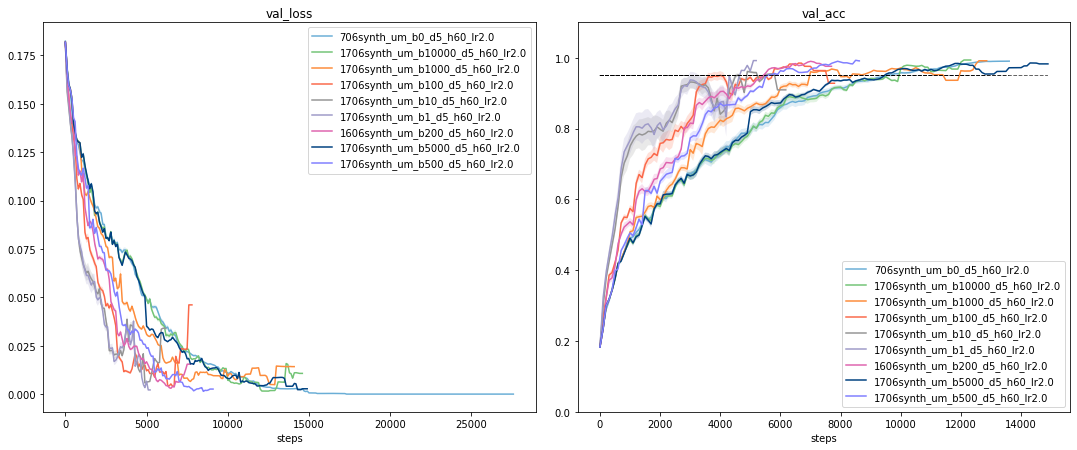

Dist values:   synth_um_b0_d5_h60_lr2.0_rep0: 0.204  || synth_um_b10000_d5_h60_lr2.0_rep0: 0.208  || synth_um_b1000_d5_h60_lr2.0_rep0: 0.163  || synth_um_b100_d5_h60_lr2.0_rep0: 0.059  || synth_um_b10_d5_h60_lr2.0_rep0: 0.011  || synth_um_b200_d5_h60_lr2.0_rep0: 0.097  || synth_um_b5000_d5_h60_lr2.0_rep0: 0.203  || synth_um_b500_d5_h60_lr2.0_rep0: 0.134  || 
#logged paths : 9 
merged_2602173_1606_2209_synth_um_b0_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602203_1706_0015_synth_um_b1_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602233_1706_0146_synth_um_b10_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602263_1706_0242_synth_um_b100_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602293_1706_0332_synth_um_b200_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602323_1706_0510_synth_um_b500_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602353_1706_0626_synth_um_b1000_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602383_1706_0800_synth_um_b5000_d6_h120_lr2.0_rep0  #folds: 30   || merged_2602413_1706_095

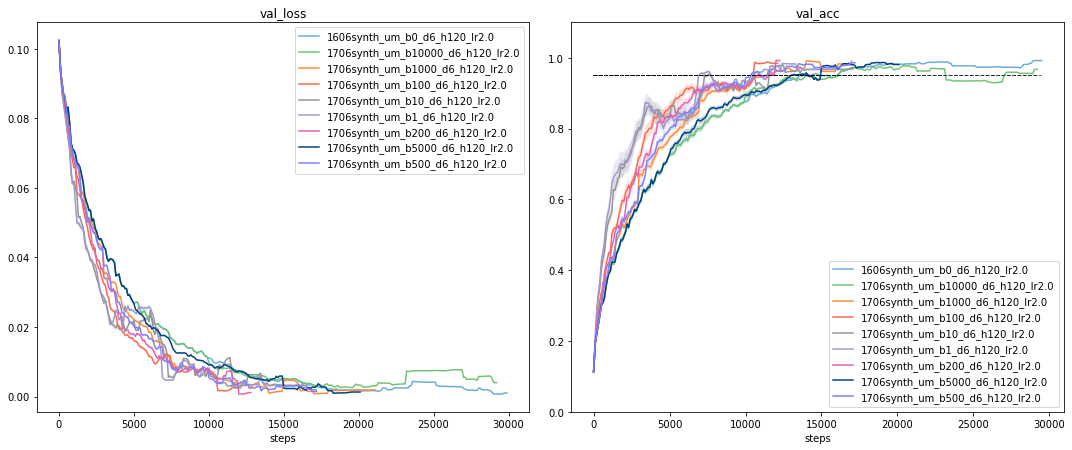

Dist values:   synth_um_b0_d6_h120_lr2.0_rep0: 0.097  || synth_um_b10000_d6_h120_lr2.0_rep0: 0.095  || synth_um_b1000_d6_h120_lr2.0_rep0: 0.055  || synth_um_b100_d6_h120_lr2.0_rep0: 0.023  || synth_um_b10_d6_h120_lr2.0_rep0: 0.007  || synth_um_b200_d6_h120_lr2.0_rep0: 0.042  || synth_um_b5000_d6_h120_lr2.0_rep0: 0.087  || synth_um_b500_d6_h120_lr2.0_rep0: 0.046  || 
#logged paths : 9 
merged_2555412_0706_1459_synth_um_b0_d7_h250_lr2.0_rep0  #folds: 50   || merged_2607018_1806_2323_synth_um_b1_d7_h250_lr2.0_rep0  #folds: 30   || merged_2607048_1806_2323_synth_um_b10_d7_h250_lr2.0_rep0  #folds: 28   || merged_2607078_1806_2323_synth_um_b100_d7_h250_lr2.0_rep0  #folds: 30   || merged_2607108_1906_0204_synth_um_b200_d7_h250_lr2.0_rep0  #folds: 30   || merged_2605001_1706_2341_synth_um_b500_d7_h250_lr2.0_rep0  #folds: 29   || merged_2605031_1706_2341_synth_um_b1000_d7_h250_lr2.0_rep0  #folds: 29   || merged_2605061_1806_0343_synth_um_b5000_d7_h250_lr2.0_rep0  #folds: 30   || merged_2605091_

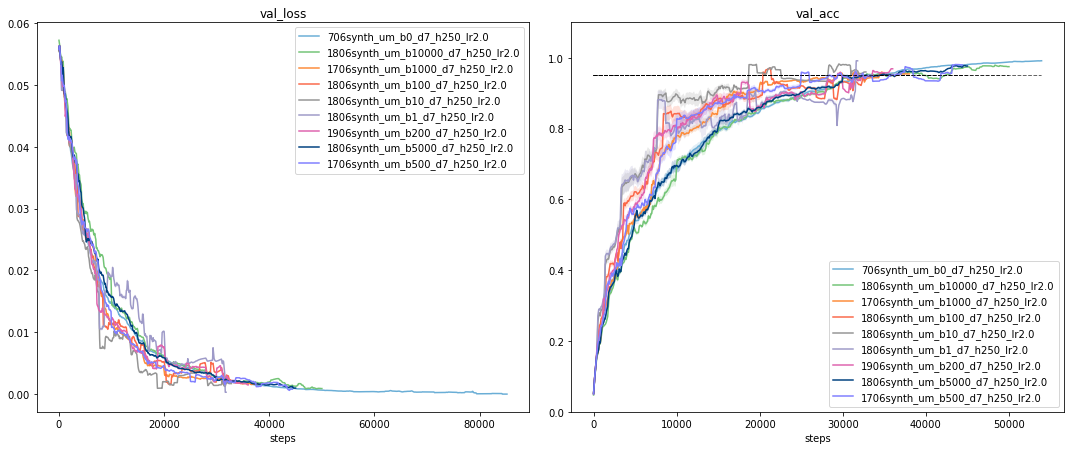

Dist values:   synth_um_b0_d7_h250_lr2.0_rep0: 0.050  || synth_um_b10000_d7_h250_lr2.0_rep0: 0.060  || synth_um_b1000_d7_h250_lr2.0_rep0: 0.006  || synth_um_b100_d7_h250_lr2.0_rep0: -0.010  || synth_um_b10_d7_h250_lr2.0_rep0: -0.053  || synth_um_b200_d7_h250_lr2.0_rep0: -0.001  || synth_um_b5000_d7_h250_lr2.0_rep0: 0.047  || synth_um_b500_d7_h250_lr2.0_rep0: 0.001  || 
#logged paths : 9 
merged_2556663_0706_1827_synth_um_b0_d8_h500_lr5.0_rep0  #folds: 10   || merged_2607152_1906_0634_synth_um_b1_d8_h500_lr5.0_rep0  #folds: 30   || merged_2607212_1906_1122_synth_um_b10_d8_h500_lr5.0_rep0  #folds: 30   || merged_2607272_1906_1607_synth_um_b100_d8_h500_lr5.0_rep0  #folds: 30   || merged_2607332_1906_2056_synth_um_b200_d8_h500_lr5.0_rep0  #folds: 30   || merged_2607140_1906_0508_synth_um_b500_d8_h500_lr5.0_rep0  #folds: 29   || merged_2607189_1906_0946_synth_um_b1000_d8_h500_lr5.0_rep0  #folds: 30   || merged_2607249_1906_1414_synth_um_b5000_d8_h500_lr5.0_rep0  #folds: 30   || merged_26073

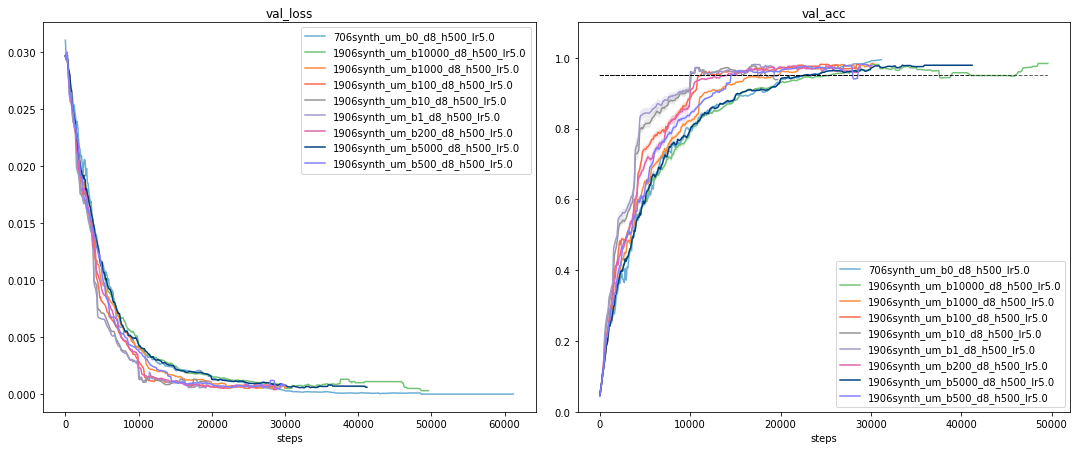

Dist values:   synth_um_b0_d8_h500_lr5.0_rep0: 0.124  || synth_um_b10000_d8_h500_lr5.0_rep0: 0.125  || synth_um_b1000_d8_h500_lr5.0_rep0: 0.088  || synth_um_b100_d8_h500_lr5.0_rep0: 0.041  || synth_um_b10_d8_h500_lr5.0_rep0: 0.011  || synth_um_b200_d8_h500_lr5.0_rep0: 0.050  || synth_um_b5000_d8_h500_lr5.0_rep0: 0.120  || synth_um_b500_d8_h500_lr5.0_rep0: 0.075  || 
#logged paths : 9 
merged_2604990_1706_2341_synth_split_b0_d5_s400_h60_lr1.0_rep0  #folds: 40   || merged_2604992_1706_2341_synth_split_b1_d5_s400_h60_lr1.0_rep0  #folds: 37   || merged_2604994_1706_2341_synth_split_b10_d5_s400_h60_lr1.0_rep0  #folds: 39   || merged_2607381_2006_0104_synth_split_b100_d5_s400_h60_lr1.0_rep0  #folds: 40   || merged_2607383_2006_0113_synth_split_b200_d5_s400_h60_lr1.0_rep0  #folds: 36   || merged_2714064_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep0  #folds: 63   || merged_2714093_0407_1112_synth_split_b1600_d5_s400_h60_lr1.0_rep0  #folds: 53   || merged_2637385_2406_0617_synth_split_b2000

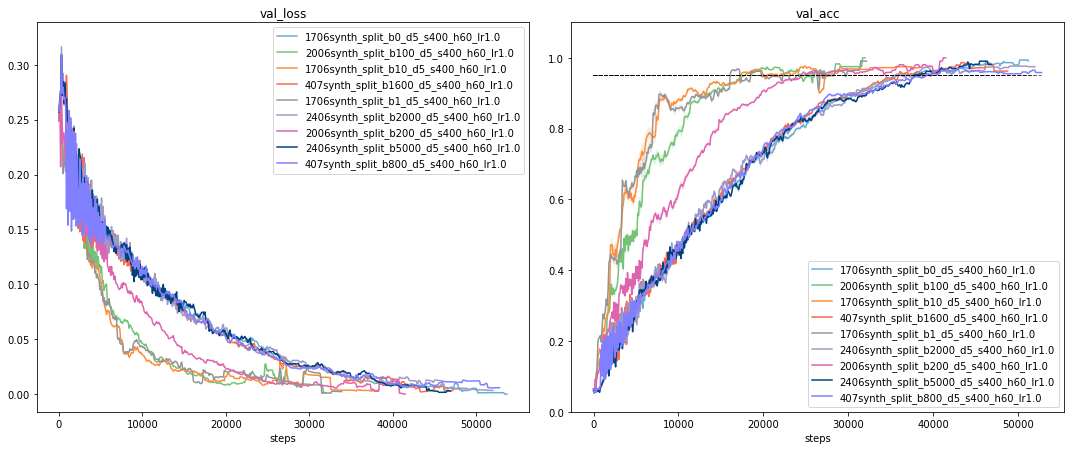

Dist values:   synth_split_b0_d5_s400_h60_lr1.0_rep0: 0.249  || synth_split_b100_d5_s400_h60_lr1.0_rep0: 0.029  || synth_split_b10_d5_s400_h60_lr1.0_rep0: -0.004  || synth_split_b1600_d5_s400_h60_lr1.0_rep0: 0.238  || synth_split_b2000_d5_s400_h60_lr1.0_rep10: 0.240  || synth_split_b200_d5_s400_h60_lr1.0_rep0: 0.109  || synth_split_b5000_d5_s400_h60_lr1.0_rep10: 0.248  || synth_split_b800_d5_s400_h60_lr1.0_rep0: 0.239  || 
#logged paths : 11 
merged_2637426_2406_0922_synth_split_b0_d6_s400_h120_lr1.0_rep0  #folds: 30   || merged_2626830_2106_1949_synth_split_b0_d6_s400_h120_lr1.0_rep0  #folds: 20   || merged_2626850_2106_1949_synth_split_b1_d6_s400_h120_lr1.0_rep0  #folds: 25   || merged_2637456_2406_1510_synth_split_b1_d6_s400_h120_lr1.0_rep0  #folds: 30   || merged_2626870_2106_1949_synth_split_b10_d6_s400_h120_lr1.0_rep0  #folds: 20   || merged_2637486_2406_2121_synth_split_b10_d6_s400_h120_lr1.0_rep0  #folds: 32   || merged_2637516_2506_0107_synth_split_b100_d6_s400_h120_lr1.0_rep0

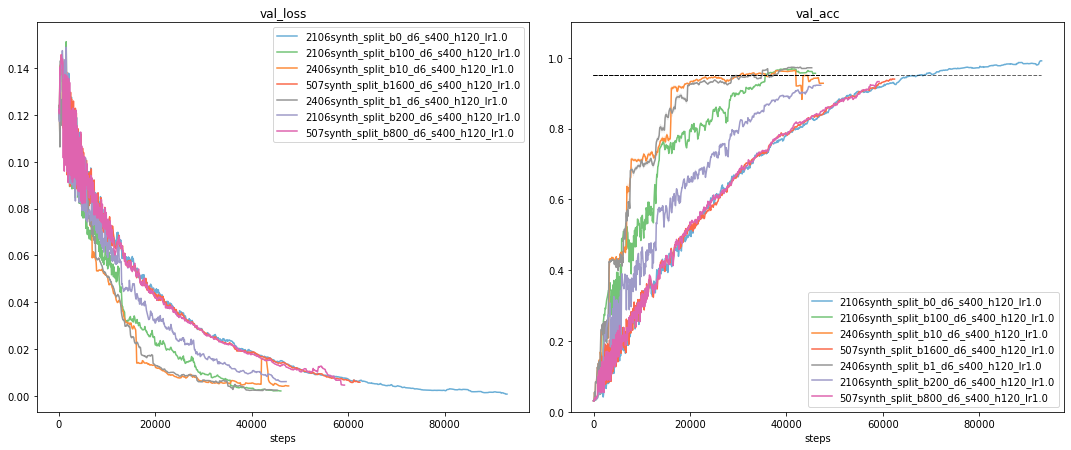

Dist values:   synth_split_b0_d6_s400_h120_lr1.0_rep0: 0.290  || synth_split_b100_d6_s400_h120_lr1.0_rep0: 0.071  || synth_split_b10_d6_s400_h120_lr1.0_rep0: -0.001  || synth_split_b1600_d6_s400_h120_lr1.0_rep0: 0.284  || synth_split_b200_d6_s400_h120_lr1.0_rep0: 0.172  || synth_split_b800_d6_s400_h120_lr1.0_rep0: 0.280  || 
#logged paths : 4 
merged_2681006_2806_1214_synth_split_b0_d7_s800_h250_lr1.0_rep3  #folds: 2   || merged_2681033_2806_1234_synth_split_b1_d7_s800_h250_lr1.0_rep0  #folds: 30   || merged_2681063_2806_2231_synth_split_b10_d7_s800_h250_lr1.0_rep0  #folds: 30   || merged_2681093_2906_0032_synth_split_b100_d7_s800_h250_lr1.0_rep0  #folds: 30   || 

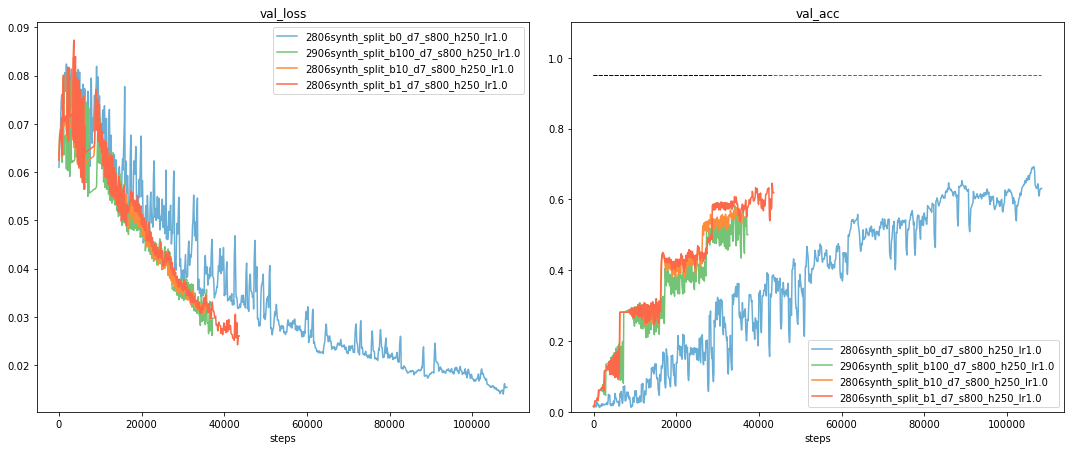

Dist values:   synth_split_b0_d7_s800_h250_lr1.0_rep3: 0.249  || synth_split_b100_d7_s800_h250_lr1.0_rep0: 0.044  || synth_split_b10_d7_s800_h250_lr1.0_rep0: 0.008  || 


In [379]:

integral_values_dict_um, integral_values_dict_split = dict(), dict()
patts_to_search_um = ['synth(?:corr)*_um_b[0-9]*_d5_+h60_lr2', 'synth_um_b[0-9]*_d6_+h120_lr2', 'synth_um_b[0-9]*_d7_+h250_lr2', 'synth_um_b[0-9]*_d8_+h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
patts_to_search_split = ['synth_split_b[0-9]*_d5_*(s[0-9]*)*_h[0-9]+_lr', 'synth_split_b[0-9]*_d6_*(s[0-9]*)*_h[0-9]+_lr', 'synth_split_b[0-9]*_d7_*(s[0-9]*)*_h[0-9]+_lr']

for res_dict, patt_list, log_path in zip([integral_values_dict_um, integral_values_dict_split],
                                         [patts_to_search_um, patts_to_search_split], 
                                         [MERGED_LOG_PATH, SPLIT_MERGED_LOG_PATH]):
    for patt in patt_list: 
        val_accs_dict = plot_runs_w_regex(patt, 0.1, log_path, verbose=0, delete_dir=False)
        integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
        print_dict(integral_values)
        res_dict[name] = (integral_values, b0_max_idx)

/Users/jeromjeromee/opt/anaconda3/envs/env1/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


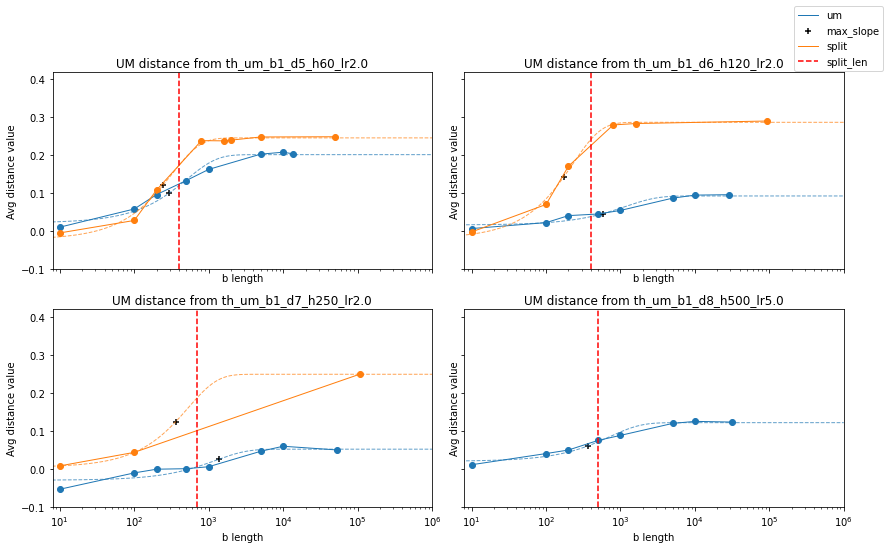

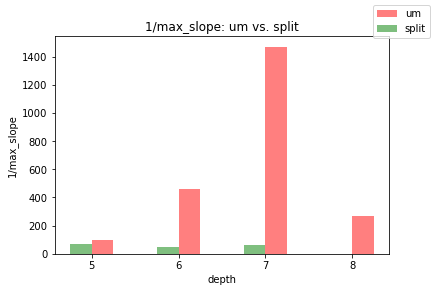

In [382]:
import seaborn as sns
from scipy.optimize import curve_fit

def sigmoid_el(x, a=1, b=0, c=0):
    return 1 / (1 + np.exp(-x*a+b)) + c

def d_sigmoid_el(x, a=1, b=0, c=0):
        return sigmoid_el(x, a, b, c) * (1 - sigmoid_el(x, a, b))

def d_sigmoid(x, a=1, b=0, c=0):
    if isinstance(x, list):
        return [d_sigmoid_el(el,a,b, c) for el in x]
    else:
        return d_sigmoid_el(x,a,b,c )

def sigmoid(x, a=1, b=0, c=0):
    if isinstance(x, list):
        return [sigmoid_el(el, a, b, c) for el in x]
    else:
        return sigmoid_el(x, a, b, c)

y_lim_vals = (-0.1, 0.42)
x_lim_vals = (8, 1e6)
f, ax = plt.subplots(2, 2, sharex=True, sharey=True)
f.set_size_inches(12,7)
ax,max_slope_um, max_slope_split=plot_b_len_dist(ax, integral_values_dict_um, integral_values_dict_split, y_lim_vals, x_lim_vals)

s_lens = [400, 400, 700, 500]
ax=plot_split_lens(ax, s_lens, y_lim_vals)

f.tight_layout(pad=0.9, w_pad=0.9, h_pad=1.0)
f.legend(bbox_to_anchor=(0.53, 0.59, 0.5, 0.5))
f.savefig(f'../plots/distance_from_b1_plot.jpg', dpi=300, bbox_inches='tight')
plt.show()

f, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax=plot_max_slope_figure(ax, max_slope_um, max_slope_split)
f.legend()
f.savefig(f'../plots/max_slope_vs_depth_barplot.jpg', dpi=300, bbox_inches='tight')
plt.show()

## MNIST Dataset

In [ ]:
integral_values_dict = dict()
patts_to_search2 = ['mnist_[a-z_0-9]*_lr0.01']
#patts_to_search2 = ['synth_split_b0_d5','synth_split_b1_d5','synth_split_b10+_d5','synth_split_b[0-9]*_d5']
#patts_to_search2 = ['synth_split_*_d5','synth_split_*_d6','synth_split_*_d7',]

# Mnist lr is 0.01
for patt in patts_to_search2: 
    val_accs_dict = plot_runs_w_regex(patt, 0.1, DL_LOG_PATH, verbose=True, delete_dir=False)
    integral_values = compute_integral_values(val_accs_dict)
    print('integral_values', integral_values)
    integral_values_dict[patt] = integral_values

FileNotFoundError: [Errno 2] No such file or directory: '../dl_logs/logs/'

# Log folds merger

In [361]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = '(?:merged_)*([0-9]{7})_[0-9]{4}_[0-9]{4}_((?:synth|mnist)(?:corr)*_(?:um|rand|split)_b[0-9]+_*(?:d[0-9]+)*_*(?:stoch)*(?:s[0-9]*)*_h[0-9]+_lr[0-9.]+)'
    #2610722_2006_1151_mnist_um_b1_h70_lr0.01_rep0
    matched = []
    for el in all_ckpt_dirs:
        matched.append(re.match(patt, el))
        if not re.match(patt, el):
            print(el)
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    dup_hashes = np.array(dup_hashes)
    print(dup_hashes)
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    #rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = np.array([el for el in all_ckpt_dirs if "DS_Store" not in el])
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            if not os.path.isdir(fold):
                print(fold)
                assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]

            for part_x in list_folds:
                foldnb2 = int(re.match('fold_([0-9]+)', part_x).group(1))
                foldstr2 = re.match('(fold_[0-9]+(?:_part[0-9]+)*)', part_x).group(1)

                source_path = join(fold, part_x) #2735590_0607_1021_synth_split_b100_d5_s400_h60_lr1.0_rep17/metrics/fold_x(_partx)
                do_move=True

                # Check if file already exists
                hyp_dest_path = join(dest_path, foldstr2)
                if os.path.isdir(hyp_dest_path):
                    print(hyp_dest_path,'exists in the destination path!')
                    # pick the ckpt w the highest step #
                    logs_path = source_path[:source_path.rfind('/')]
                    print(logs_path, dest_path)
                    max_step_source = parse_tb_logs(logs_path, metrics_to_plot, threshold=0.1, verbose=False, delete_dir=False, 
                                  parse_hparams=False, only_max_step=True, one_fold=foldnb2)
                    max_step_dest = parse_tb_logs(dest_path, metrics_to_plot, threshold=0.1, verbose=False, delete_dir=False, 
                                  parse_hparams=False, only_max_step=True, one_fold=foldnb2)
                    print(max_step_source, max_step_dest)
                    if max_step_source > max_step_dest:
                        shutil.rmtree(hyp_dest_path)
                    else:
                        do_move=False

                    #new_source_path = join(source_path[:source_path.rfind('/')], f'fold_{foldnb2}_part2')
                    #os.rename(source_path, new_source_path)
                    #source_path = new_source_path

                if do_move:
                    shutil.move(source_path, dest_path)

            
            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                


merge_folds(TO_MERGE_LOG_PATH)


['synth_split_b800_d5_s400_h60_lr1.0' 'synthcorr_um_b1_d6_h120_lr2.0'
 'synth_split_b1600_d6_s400_h120_lr1.0'
 'synth_split_b1600_d5_s400_h60_lr1.0' 'synthcorr_um_b0_d6_h120_lr2.0'
 'synthcorr_um_b100_d6_h120_lr2.0' 'synth_split_b800_d6_s400_h120_lr1.0'
 'synthcorr_um_b10_d6_h120_lr2.0' 'synth_split_b2000_d5_s400_h60_lr1.0'
 'synthcorr_um_b2000_d6_h120_lr2.0' 'synthcorr_um_b1000_d6_h120_lr2.0'
 'synth_split_b1_d6_s400_h120_lr1.0' 'synth_split_b100_d6_s400_h120_lr1.0'
 'synth_split_b10_d5_stochs400_h60_lr1.0'
 'synth_split_b5000_d5_s400_h60_lr1.0'
 'synth_split_b10_d6_s400_h120_lr1.0' 'synth_split_b200_d5_s400_h60_lr1.0'
 'synth_split_b1_d5_stochs400_h60_lr1.0']
[array(['2714067_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep4',
       '2714074_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep11',
       '2714075_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep12',
       '2714066_0407_1112_synth_split_b800_d5_s400_h60_lr1.0_rep3',
       '2714065_0407_1112_synth_split_b800_d5_s400_h60_

In [ ]:
with open(join(DL_PATH, 'failed_relaunch_jobs.txt'), 'r') as csvfile:
    lines = csvfile.readlines()
    
lines = [el[:7] for el in lines]
print(lines)
for el in os.listdir(DL_LOG_PATH):
    
    if el[:7] in lines:
        print(el)
        shutil.rmtree(join(DL_LOG_PATH, el))

In [265]:
a = [0,1,2,3]
print(a)
print(a[:len(a)-1])

[0, 1, 2, 3]
[0, 1, 2]
